In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)

traintransform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5)) 
])

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), 
                                      (0.5, 0.5, 0.5))
    ])


trainset_complete = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=traintransform)

trainset, valset = torch.utils.data.random_split(trainset_complete, [45000, 5000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=64,
                                        shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

1.12.1
Files already downloaded and verified
Files already downloaded and verified


In [2]:
class TinyVGG(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=4*4*20, out_features=num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        return self.layers(x)

In [3]:
def compute_accuracy(model, loader):
    total, correct = 0, 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        total += len(inputs)
        correct += (model(inputs).argmax(dim=1).cpu() == labels).sum()
    return correct/total

In [4]:
device = torch.device('cpu')

In [5]:
cross_entropy = nn.CrossEntropyLoss()
model = TinyVGG().to(device)

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500,2000], gamma=0.1)

In [7]:
epochs = -1
val_acc = []
best_acc = 0.0
for i in range(0, epochs):
    for j,(inputs, labels) in enumerate(trainloader):
        
        # put data on device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)
        
        # training loss
        loss = cross_entropy(outputs, labels)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
    # compute validation accuracy
    val_acc.append(compute_accuracy(model, valloader))
    
    if best_acc < val_acc[-1]:
        torch.save(model.state_dict(), 'tiny-vgg-checkpoint-best.pth')
        best_acc = val_acc[-1]
    scheduler.step()
    
    print("epoch: {:2} loss: {:3.4} val accuracy {:3.4}".format(i+1, loss.item(), val_acc[-1]))

In [8]:
model.load_state_dict(torch.load('tiny-vgg-checkpoint-best.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
# compute accuracy on training data
compute_accuracy(model, trainloader)

tensor(0.7914)

In [10]:
# compute accuracy on test data
compute_accuracy(model, testloader)

tensor(0.7880)

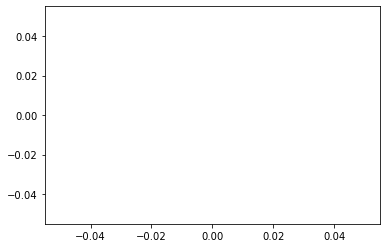

In [11]:
import matplotlib.pyplot as plt
plt.plot(val_acc)

In [12]:
#torch.save( model.state_dict(), 'tiny-vgg-checkpoint.pth')

In [13]:
def normalize(batch):
    return (batch-batch.min())/(batch.max()-batch.min())

In [14]:
def count_params(model):
    parameter_list = [p.numel() for p in model.parameters() if p.requires_grad]
    return sum(parameter_list)

count_params(model)

22466

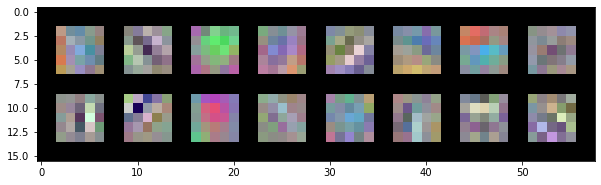

In [15]:
from torchvision.utils import make_grid
params = list(model.parameters())
f = params[0].detach()
f = normalize(f) # normalize filters to [0,1]
plt.figure(figsize=(10,10))
plt.imshow(make_grid(f).permute(1,2,0))

In [16]:
testbatch, testlabels = iter(testloader).next()
x = testbatch.clone()
for i, layer in enumerate(model.layers):
    if i > 1: break
    x = layer(x)

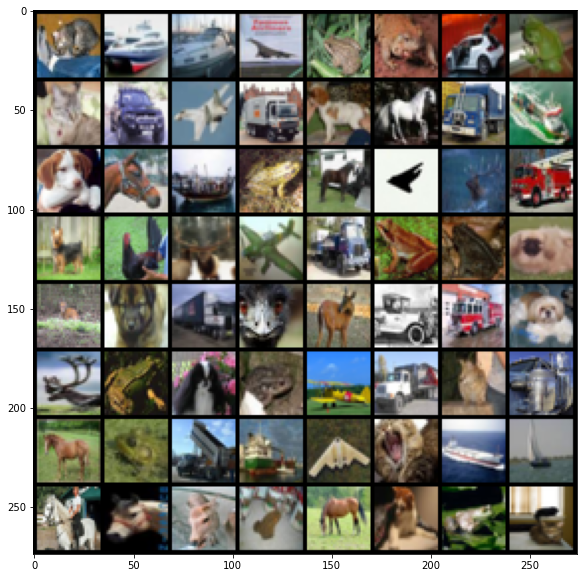

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(make_grid(normalize(testbatch)).permute(1,2,0))

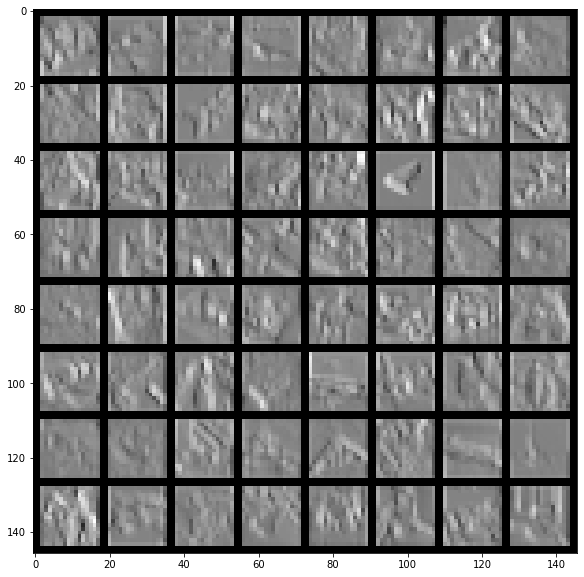

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(make_grid(normalize(x)).permute(1,2,0)[:,:,0], cmap='gray')